#**Unet**

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

!chmod 600 /content/kaggle.json
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip \*.zip
!rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, Convolution2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, AveragePooling2D, UpSampling2D, Dropout, ZeroPadding2D
from tensorflow.keras.layers import Add, Lambda, ReLU, LeakyReLU, concatenate
from tensorflow.keras.applications import MobileNetV2

from warnings import filterwarnings
filterwarnings('ignore')
import random
from glob import glob
from IPython.display import display

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prepare dataset

In [4]:
#Set Parameters
im_width = 256
im_height = 256

# **Load image's path and mask's path**

In [5]:
train_files = []
mask_files = glob('/content/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_54.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_16.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_46.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_17.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_56.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_4.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_14.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_21.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_19.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_5.tif']
['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_198605

# **Data Visualization**

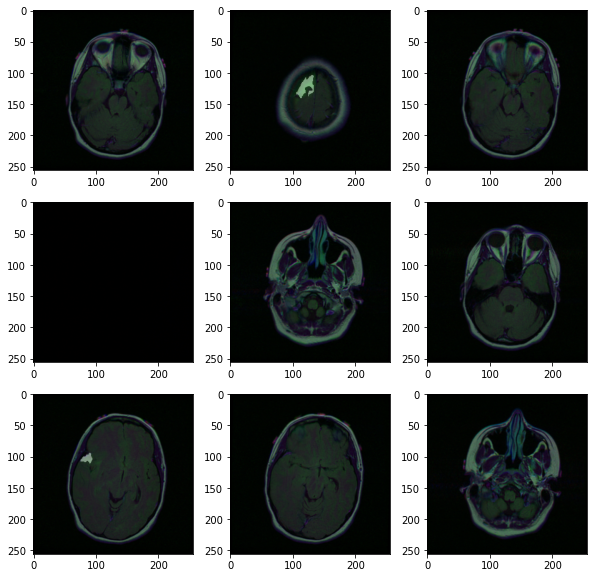

In [6]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

## **Create data frame and split data on train set, validation set and test set**

In [7]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


## **Data genertator, data augmentation and adjust data**

In [8]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

##**Model**

In [9]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D()(conv)        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [10]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)    
    return conv

In [24]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=1):
    inputs = Input(input_size)
    # Encoder
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8)
    cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob=0.3) # Include a dropout of 0.3 for this layer
    # Bridge
    cblock6 = conv_block(cblock5[0], n_filters*32, dropout_prob=0.3, max_pooling=False) 
    #Decoder
    ublock7 = upsampling_block(cblock6[0], cblock5[1],  n_filters * 16)
    ublock8 = upsampling_block(ublock7, cblock4[1],  n_filters * 8)
    ublock9 = upsampling_block(ublock8, cblock3[1],  n_filters * 4)
    ublock10 = upsampling_block(ublock9, cblock2[1],  n_filters * 2)
    ublock11 = upsampling_block(ublock10, cblock1[1],  n_filters)

    conv12 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock11)

    conv13 = Conv2D(n_classes, 1, padding='same')(conv12)
    activation14 = Activation('sigmoid')(conv13)
    model = tf.keras.Model(inputs=inputs, outputs=activation14)

    return model

In [25]:
img_height = 256
img_width = 256
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [26]:
unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_64 (Conv2D)             (None, 256, 256, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_65 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_64[0][0]']              
                                )                                                           

In [30]:
from tensorflow.keras import backend as K
EPOCHS = 100
BATCH_SIZE = 16
learning_rate = 0.01
epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [31]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(learning_rate = learning_rate, epsilon = 0.1)
unet.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=30
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/content/Model1_Unet_BrainMriSeg.h5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [32]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
history = unet.fit(train_gen, 
                  epochs = EPOCHS,
                  steps_per_epoch=len(df_train) / BATCH_SIZE,
                  validation_data = val_gen,
                  validation_steps=len(df_val) / BATCH_SIZE,
                  callbacks = [checkpointer, earlystopping, reduce_lr])

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/100
177/176 [==============================] - ETA: 0s - loss: 0.9719 - tversky: 0.0373
Epoch 1: val_loss improved from inf to 0.96933, saving model to /content/Model1_Unet_BrainMriSeg.h5
176/176 [==============================] - 92s 512ms/step - loss: 0.9719 - tversky: 0.0373 - val_loss: 0.9693 - val_tversky: 0.0403 - lr: 0.0100
Epoch 2/100
177/176 [==============================] - ETA: 0s - loss: 0.9636 - tversky: 0.0481
Epoch 2: val_loss improved from 0.96933 to 0.96220, saving model to /content/Model1_Unet_BrainMriSeg.h5
176/176 [==============================] - 86s 485ms/step - loss: 0.9636 - tversky: 0.0481 - val_loss: 0.9622 - val_tversky: 0.0492 - lr: 0.0100
Epoch 3/100
177/176 [==============================] - ETA: 0s - loss: 0.9413 - tversky: 0.0772
Epoch 3: val_loss improved from 0.96220 to 0.72863, saving model to /content/Model1_Unet_BrainMriSeg.h5
176/176 [=============================

## Model Evaluation

In [33]:
history.history.keys()

dict_keys(['loss', 'tversky', 'val_loss', 'val_tversky', 'lr'])

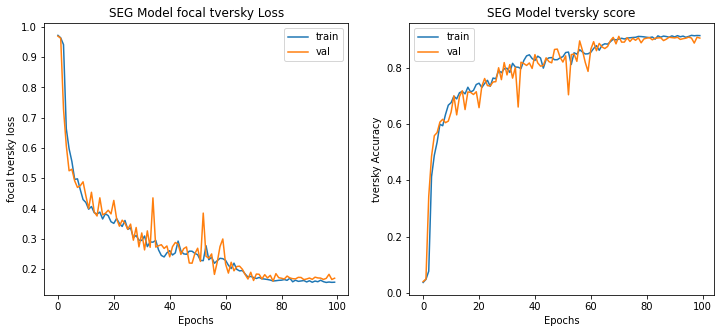

In [34]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history.history['tversky']);
plt.plot(history.history['val_tversky']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

## Segmantation Model Performance 

In [35]:
from google.colab import drive
drive.mount('/content/drive')

unet = load_model("/content/Model1_Unet_BrainMriSeg.h5",custom_objects={"focal_tversky":focal_tversky,"tversky":tversky,"tversky_loss":tversky_loss})

unet.save('/content/drive/MyDrive/Colab Notebooks/Model1_Unet_BrainMriSeg.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width))
results = unet.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)

Found 393 validated image filenames.
Found 393 validated image filenames.
24/24 [==============================] - 6s 221ms/step - loss: 0.2036 - tversky: 0.8769


In [37]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred= unet.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.